## Notes

- In de laatste cell is het plotten de limiterende factor

## Check/To do

- Velocity kick
- Maak V_orbit vs a_orbit plot tijdens simulatie en check of objecten die V_esc overschrijden ook daadwerkelijk escapen

In [1]:
#Here we import all the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from IPython.display import clear_output
from amuse.lab import units, constants
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import get_orbital_elements_from_binaries
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.lab import Rebound
from amuse.lab import Mercury
from amuse.community.ph4.interface import ph4
from amuse.io import write_set_to_file, read_set_from_file

In [2]:
# Function to generate random orbits for asteroids in the Solar System.
def random_positions_and_velocities(N_objects, sun_loc):  
    positions = np.zeros((N_objects, 3)) | units.AU
    velocities = np.zeros((N_objects,3)) | units.kms
    
    m_sun = 1 | units.MSun
    m_oort = 0 | units.MSun
    for i in range(N_objects):
        # Values below correspond with random locations anywhere in the Solar System
        a = np.random.uniform(4, 40) | units.AU  # semi-major axis
        e = np.random.uniform(0, 0.05)  # eccentricity
        inclination = np.random.uniform(-5, 5) | units.deg
        true_anomaly = np.random.uniform (0, 360) | units.deg
        arg_of_periapsis = np.random.uniform(0, 360) | units.deg
        long_of_ascending_node = np.random.uniform(0, 360) | units.deg
        sun_and_oort = new_binary_from_orbital_elements(m_sun, m_oort, 
                                          a, e, true_anomaly, inclination, long_of_ascending_node, arg_of_periapsis, G=constants.G)
        positions[i] = (sun_and_oort[1].x+sun_loc[0]), (sun_and_oort[1].y+sun_loc[1]), (sun_and_oort[1].z+sun_loc[2])
        velocities[i]= sun_and_oort[1].vx, sun_and_oort[1].vy, sun_and_oort[1].vz
    return positions, velocities

In [3]:
def merge_two_bodies(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Actually merger occurred:")
    print("Two objects (M=",particles_in_encounter.mass.in_(units.MSun),
          ") collided with d=", d.length().in_(units.au))
    #time.sleep(10)
    new_particle=Particles(1)
    new_particle.mass = particles_in_encounter.total_mass()
    new_particle.position = com_pos
    new_particle.velocity = com_vel
    new_particle.radius = ((particles_in_encounter.radius**3).sum())**(1./3.) # New radius cannot simply be summed
    bodies.add_particles(new_particle)
    bodies.remove_particles(particles_in_encounter)

In [4]:
# To resolve a collision between two or more particles, we merge them together using their center of mass (velocity).
def resolve_collision(collision_detection, gravity_code, bodies, time):
    print("Well, we have an actual collision between two or more objects.")
    print("This happened at time=", time.in_(units.yr))
    for ci in range(len(collision_detection.particles(0))):  # Multiple pairs of collisions could take place in one timestep
        encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
        colliding_objects = encountering_particles.get_intersecting_subset_in(bodies)
        merge_two_bodies(bodies, colliding_objects)
        bodies.synchronize_to(gravity_code.particles) # Update bodies to contain 1 particle instead of 2

In [5]:
#Here we generate a basic solarsystem, with only the gas giants
from amuse.ext.solarsystem import new_solar_system

def create_system():
    system = new_solar_system()
    system = system[system.mass > 10**-5 | units.MSun] # Takes gas giants and Sun only
    system.move_to_center()
    return system
    
    
basic_giants_system = create_system()

|S11


In [6]:
#Define the number of asteroids and create random velocities and positions
N_objects = 1*10**2
sun_loc = [basic_giants_system[0].x.in_(units.AU), basic_giants_system[0].y.in_(units.AU), basic_giants_system[0].z.in_(units.AU)]
positions, velocities = random_positions_and_velocities(N_objects, sun_loc)

In [7]:
# Here we add the asteroids, where orbit parameters were chosen from a uniform distribution
def add_comet_objects(system, N_objects, rand_pos, rand_vel):
    for i in tqdm(range(N_objects)):
        oort = Particles(1)
        oort.name = "OORT_" + str(i)
        oort.mass = 0.0 | units.MSun
        oort.radius = (2.3 | units.km).in_(units.RSun) # This is purely non-zero for collisional purposes
        oort.position = (rand_pos[i, 0], rand_pos[i, 1], rand_pos[i, 2])
        oort.velocity = (rand_vel[i, 0], rand_vel[i, 1], rand_vel[i, 2])

        system.add_particle(oort)
    return system

complete_system = add_comet_objects(basic_giants_system, N_objects, positions, velocities)

100%|██████████| 100/100 [00:00<00:00, 615.43it/s]


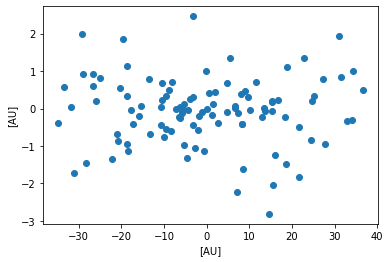

In [8]:
#plot the distribution in the orbital plane
import amuse.plot as plot
plot.scatter(complete_system.x, complete_system.z)

In [9]:
#Here we create the conditions for the migration of the planets

def in_migration_jup(t_now, t_prev, tau, dv):
    velocity_kick = (dv*(t_now-t_prev)/tau)
    return velocity_kick

final_system = complete_system
final_system.move_to_center()

In [10]:
#Here we perform the conversion for the system
converter_length = get_orbital_elements_from_binary(final_system[0:2], G = constants.G)[2].in_(units.AU) # Typical distance used for calculation (=distance from Sun to Jupiter)
final_converter=nbody_system.nbody_to_si(final_system.mass.sum(), 
                                   converter_length)

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


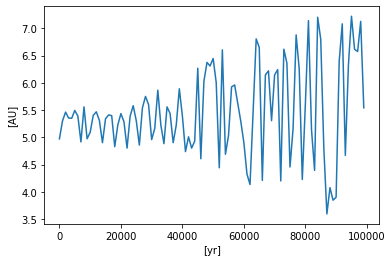

In [11]:
#Here we evolve the basic system, without grandtack or Milky way potential

def vanilla_evolver(particle_system, converter, N_objects, end_time=4*10**3, time_step=0.1):
    
    names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
    
    if N_objects > 2*10**3:
        gravity_code = Mercury(final_converter) # Runs smoother with many particles
    else:
        gravity_code = ph4(final_converter)
    
    stopping_condition = gravity_code.stopping_conditions.collision_detection
    stopping_condition.enable()
    
    gravity_code.particles.add_particles(particle_system)
    ch_g2l = gravity_code.particles.new_channel_to(particle_system)
    
    times = np.arange(0., end_time, time_step) | units.yr
    
    ajup = np.zeros(len(times)) | units.AU
    
    for i in tqdm(range(len(times))):
        gravity_code.evolve_model(times[i])
        
        tau = 10**5 | units.yr
        dv = 1 | units.kms
        
        if i > 0:
            gravity_code.particles[1].velocity = ((gravity_code.particles[1].velocity.length()+in_migration_jup(times[i], times[i-1], tau, dv))/gravity_code.particles[1].velocity.length())*gravity_code.particles[1].velocity
        ajup[i] = gravity_code.particles[1].position.length()
        #if stopping_condition.is_set(): # If objects collide, merge them
        #    resolve_collision(stopping_condition, gravity_code, particle_system, times[i])
        ch_g2l.copy()
                
    
        
        if times[i] == (end_time-time_step) | units.day:
            
            plot.scatter(gravity_code.particles.x.in_(units.AU), gravity_code.particles.y.in_(units.AU), s= 6)
            for j in range(5):
                plot.scatter(gravity_code.particles[j].x.in_(units.AU), gravity_code.particles[j].y.in_(units.AU), label = names[j])
            plot.text(-35, 32, "Time = " + str(times[i].value_in(units.yr))[0:7] + " yrs.")
            plt.legend()
            fig = plt.gcf()
            fig.set_size_inches(12, 9)
            #clear_output(wait=True) 
            plt.show()
            
    plot.plot(times, ajup)
    plt.show()
    
    gravity_code.stop()
    return particle_system
    
    
vanilla_evolved_system = vanilla_evolver(basic_giants_system, final_converter, N_objects, end_time= 10**5, time_step= 10**3)

In [12]:
#Here we evolve the basic system, with Milky way potential
def MWG_evolver(particle_system, potential, converter, N_objects, end_time=4*10**3, time_step=0.1):
    names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
    
    if N_objects > 2*10**3:
        gravity_code = Mercury(final_converter)
    else:
        gravity_code = ph4(final_converter)
    
    stopping_condition = gravity_code.stopping_conditions.collision_detection
    stopping_condition.enable()
    
    gravity_code.particles.add_particles(particle_system)
    ch_g2l = gravity_code.particles.new_channel_to(particle_system)
    
    gravity_bridge = 0
    gravity_bridge = bridge.Bridge(use_threading=False)
    gravity_bridge.add_system(gravity_code, (potential,) )
    gravity_bridge.timestep = time_step|units.day
    
    times = np.arange(0., end_time, time_step) | units.day
    for t in tqdm(times):
        #if np.array(abs(gravity_code.particles.x)).any() > 50 | units.AU or np.array(abs(gravity_code.particles.y)).any() > 50 | units.AU or np.array(abs(gravity_code.particles.z)).any() > 50 | units.AU:
        #    print('Particle coordinate reached 50 AU', t)
        gravity_bridge.evolve_model(t)
        if stopping_condition.is_set(): # If particles collide, merge them
            resolve_collision(stopping_condition, gravity_code, particle_system, t)
        ch_g2l.copy()
        
        if t == (end_time-time_step) | units.day:
            plot.scatter(gravity_bridge.particles.x.in_(units.AU), gravity_bridge.particles.y.in_(units.AU), s= 6)
            # Plotting an AU around Jupiter to see if objects are captured
            #plot.xlim(gravity_bridge.particles[1].x -  (1 | units.AU), gravity_bridge.particles[1].x + (1 | units.AU))
            #plot.ylim(gravity_bridge.particles[1].y -  (1 | units.AU), gravity_bridge.particles[1].y + (1 | units.AU))
            for i in range(5):
                plot.scatter(gravity_bridge.particles[i].x.in_(units.AU), gravity_bridge.particles[i].y.in_(units.AU), label = names[i])
            #plot.text(-35, 32, "Time = " + str(t.value_in(units.yr))[0:7] + " yrs.")
            plt.legend()
            fig = plt.gcf()
            fig.set_size_inches(12, 9)
            clear_output(wait=True) 
            plt.show()
        
    gravity_bridge.stop()
    return particle_system

#MWG_evolved_system = MWG_evolver(final_system, MW_potential, final_converter, N_objects, end_time= 10**5, time_step= 50)